In [ ]:
'''Extract Features'''
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def extract_X():

    file_path = r"ParPara_total.xlsx"

    Columns=[]
    # C-J:data of sampling points at different depths
    for i in range(16):
        df_specific_sheet = pd.read_excel(file_path, sheet_name=i+1)
        # using sheet index (the first sheet serves as the table of contents)
        for c in range(8):
            column=df_specific_sheet.iloc[:, 2+c][1:]
            Columns.append(column.values)

    samples=[]
    for i in range(49):
        
        samples.append(i)
    X=[]
    for sample in samples:
        for depth in range(8):
            features=[]
            # print(depth)
            features.append(depth*10)
            for f in range(16):
                val=Columns[f*8+depth][sample]
                features.append(val)

            X.append(features)
    X=np.array(X)
    return X
X=extract_X()
print(X.shape)


(392, 17)


In [ ]:
'''Extract Labels'''
import pandas as pd
import numpy as np
def extract_Y():

    file_path = r"particulate-phase-PAH-concentration.xlsx"
    Columns=[]
    df_specific_sheet = pd.read_excel(file_path, sheet_name="Total PAHs")  # 使用sheet索引（第一个sheet）
    for c in range(8):
        column=df_specific_sheet.iloc[:, 2+c][1:]
        Columns.append(column.values)

    Y=[]

    samples=[]
    for i in range(49):
        samples.append(i)
    for sample in samples:
        
        for depth in range(8):
            # 8列
            labels=[]

            for f in range(1):
                # f是1个sheet
                # 一个文件有8个cols
                val=Columns[f*8+depth][sample]
                labels.append(val)

            Y.append(labels)
                
    Y=np.array(Y)

    return Y

In [ ]:
# feature_names = [
#     "Depth",  0      # depth
#     "Temp",   1      # Temperature  
#     "Sal",    2      # Salinity
#     "HFVel",  3      # Horizontal Flow Velocity
#     "VFVel",  4      # Vertical Flow Velocity
#     "DO",     5      # Dissolved Oxygen
#     "DIC",    6      # Dissolved Inorganic Carbon
#     "NO3",    7      # Nitrate
#     "PO4",    8      # Phosphate
#     "SiO4",   9      # Silicate
#     "Fe2+",   10      # Dissolved Iron Ions
#     "Chl",    11      # Chlorophyll
#     "NaP",    12
#     "Phe",    13
#     "Pyr",    14 
#     "Bap"，   15
#     "Flu"，   16
# ]
'''Filter nan data'''
def filter_data(X,Y):
    Train_X=[]
    Train_Y=[]
    for i in range(len(Y)):
        label=0
        for m in range(X.shape[1]):
            if np.isnan(X[i][m]):
                label=1
                break
        if np.isnan(Y[i][0]) !=1 and label==0:
            Train_X.append(X[i])
            Train_Y.append(Y[i])

    X_Train=np.array(Train_X)
    Y_Train=np.array(Train_Y)
    cols=[]
    X_Train = np.delete(X_Train, cols, axis=1)

    print("Check shape:")
    print(X_Train.shape,Y_Train.shape)
    return X_Train,Y_Train

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from tqdm import *
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, AveragePooling1D, Flatten, Dense, Input, BatchNormalization, Activation, MaxPooling1D, LeakyReLU, SimpleRNN
from tensorflow.data import Dataset
from keras.optimizers import Adam,RMSprop,SGD,Nadam
from tensorflow.keras.regularizers import l2,l1_l2
from sklearn.model_selection import KFold
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.callbacks import EarlyStopping
print(tf.__version__)

2.15.0


In [ ]:
from tensorflow.keras.layers import Dense, Multiply, Activation,Concatenate

from tensorflow.keras.layers import Dense, Multiply, Activation,Concatenate,Add

def MCRDC_MLP(input_size,  key_feature_idx, learning_rate=0.005):
    # Input layer
    inputs = Input(shape=(input_size,))
    
    # Channel 1
    key_feature = inputs[:, key_feature_idx:]
    

    x_key_main = Dense(abs(key_feature_idx),  name='key_fc1', activation=None,kernel_initializer='he_normal')(key_feature)
    x_key_main = BatchNormalization()(x_key_main)
    x_key_main = Dropout(0.15)(x_key_main)

    x_key_main = Dense(abs(key_feature_idx),  activation=None,kernel_initializer='he_normal')(x_key_main)
    x_key_main = BatchNormalization()(x_key_main)
    x_key_main = Dropout(0.15)(x_key_main)

    x_key = Add(name='add')([x_key_main, key_feature])
    x_key = Activation('relu')(x_key)
    x_key = BatchNormalization()(x_key)
    x_key = Dropout(0.15)(x_key)

    # Channel2
    other_features = inputs[:, :key_feature_idx]
    x_other = Dense(8, activation='relu', kernel_regularizer=l2(0.05), name='other_fc1',kernel_initializer='he_normal')(other_features)
    x_other = BatchNormalization()(x_other)
    x_other = Dropout(0.3)(x_other)
    x_other = Dense(8, activation='relu', kernel_regularizer=l2(0.05), name='other_fc2',kernel_initializer='he_normal')(x_other)
    x_other = BatchNormalization()(x_other)
    x_other = Dropout(0.3)(x_other)

    # Merge
    merged = Concatenate()([x_key, x_other])
    x = Dense(128, activation='relu', name='merged_fc1',kernel_initializer='he_normal')(merged)
    x = BatchNormalization()(x)
    
    outputs = Dense(1, activation='linear')(x)

    
    model = Model(inputs, outputs)
    
    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [ ]:
'''Calculate VIF'''

X=extract_X()
Y=extract_Y()

X,Y=filter_data(X,Y)
feature_names = [
    "Depth",        # depth
    "Temp",         # Temperature  
    "Sal",          # Salinity
    "HFVel",        # Horizontal Flow Velocity
    "VFVel",        # Vertical Flow Velocity
    "DO",           # Dissolved Oxygen
    "DIC",          # Dissolved Inorganic Carbon
    "NO3",          # Nitrate
    "PO4",          # Phosphate
    "SiO4",         # Silicate
    "Fe2+",         # Dissolved Iron Ions
    "Chl",          # Chlorophyll
    "NaP",    
    "Phe",    
    "Pyr",     
    "Bap",
    "Flu"
]
df_X = pd.DataFrame(X, columns=feature_names)

env_vars = df_X.iloc[:, :12]   
pah_vars = df_X.iloc[:, 12:]   

vif_results = []

for env_name in env_vars.columns:
    # merge env with all PAHs
    df_pair = pd.concat([df_X[[env_name]], pah_vars], axis=1)
    df_pair_const = sm.add_constant(df_pair)
    # VIF
    vif_env = variance_inflation_factor(df_pair_const.values, 1)  
    vif_results.append({'Env': env_name, 'VIF': vif_env})

vif_df = pd.DataFrame(vif_results)
print(vif_df)

vif_results = []
for pah_name in pah_vars.columns:
    # merge PAH with all env
    df_pair = pd.concat([df_X[[pah_name]], env_vars], axis=1)
    df_pair_const = sm.add_constant(df_pair)
    # VIF
    vif_pah = variance_inflation_factor(df_pair_const.values, 1)
    vif_results.append({'PAH': pah_name, 'VIF': vif_pah})

vif_df_pah = pd.DataFrame(vif_results)
print(vif_df_pah)

Check shape:
(172, 17) (172, 1)
      Env       VIF
0   Depth  1.121725
1    Temp  1.278028
2     Sal  1.608978
3   HFVel  1.065784
4   VFVel  1.033550
5      DO  1.402231
6     DIC  1.262809
7     NO3  1.189940
8     PO4  1.483091
9    SiO4  1.245042
10   Fe2+  1.336165
11    Chl  1.213533
   PAH       VIF
0  NaP  1.221111
1  Phe  1.250718
2  Pyr  1.265992
3  Bap  1.458022
4  Flu  1.434030


Check shape:
(172, 17) (172, 1)

Epoch 1/250


6/6 [==============================] - 2s 44ms/step - loss: 51853496.0000 - mae: 3951.5183 - val_loss: 46614088.0000 - val_mae: 3766.2200
Epoch 2/250
6/6 [==============================] - 0s 7ms/step - loss: 51840408.0000 - mae: 3951.0583 - val_loss: 46594164.0000 - val_mae: 3766.0559
Epoch 3/250
6/6 [==============================] - 0s 6ms/step - loss: 51818280.0000 - mae: 3950.5723 - val_loss: 46566992.0000 - val_mae: 3765.4688
Epoch 4/250
6/6 [==============================] - 0s 6ms/step - loss: 51794004.0000 - mae: 3949.9885 - val_loss: 46531432.0000 - val_mae: 3764.6951
Epoch 5/250
6/6 [==============================] - 0s 7ms/step - loss: 51770520.0000 - mae: 3949.2507 - val_loss: 46492920.0000 - val_mae: 3763.9285
Epoch 6/250
6/6 [==============================] - 0s 6ms/step - loss: 51737908.0000 - mae: 3948.3735 - val_loss: 46450668.0000 - val_mae: 3763.1526
Epoch 7/250
6/6 [==============================] - 0s 6ms/step - loss:

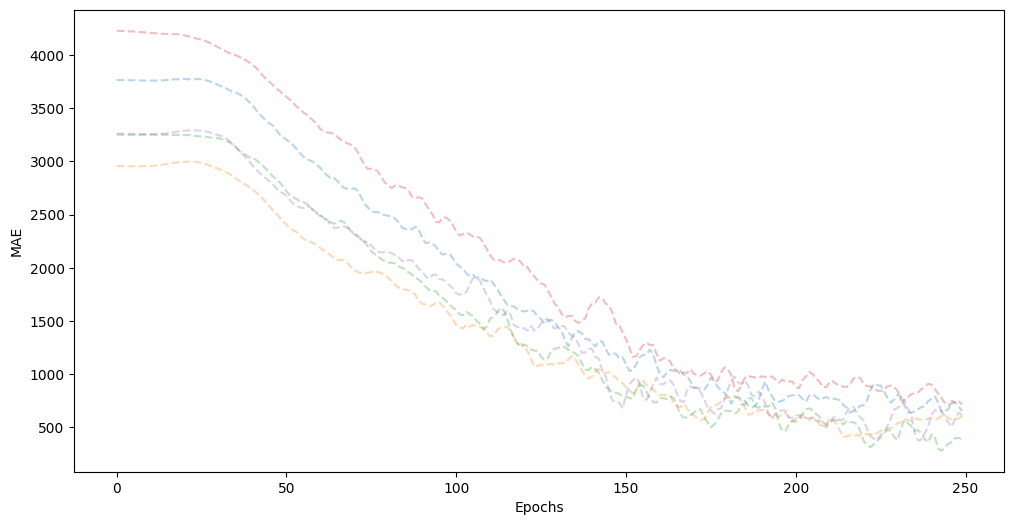

In [ ]:
X=extract_X()
Y=extract_Y()

X_all,Y_all=filter_data(X,Y)


kf = KFold(n_splits=5, shuffle=True, random_state=42)
    

fold_histories = {
    'train_loss': [], 'val_loss': [],
    'train_mae': [], 'val_mae': [],
    'test_mae': [], 'test_rmse': []
}


plt.figure(figsize=(12, 6))
data_size = len(X_all)
train_size = int(data_size * 0.8)  

# random seed
np.random.seed(42)
start_index = np.random.randint(0, data_size - train_size + 1)

# Split dataset
X_Train = X_all[start_index:start_index + train_size]  # Training set (random consecutive 80%)
X_Test = np.concatenate([X_all[:start_index], X_all[start_index + train_size:]])  # Test set (remaining 20%)
y_Train = Y_all[start_index:start_index + train_size]  # Training labels (random consecutive 80%)
Y_test = np.concatenate([Y_all[:start_index], Y_all[start_index + train_size:]])  # Test labels (remaining 20%)



scaler = StandardScaler()
for fold, (train_idx, test_idx) in enumerate(kf.split(X_Train)):
    
    
    X_train = scaler.fit_transform(X_Train[train_idx])
    X_test = scaler.transform(X_Train[test_idx])
    y_train, y_test = y_Train[train_idx], y_Train[test_idx]

    model = MCRDC_MLP(17,key_feature_idx=-5)


    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(
        X_train, y_train, test_size=0.15, random_state=42
    )
    

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=250,
        batch_size=16,
        verbose=1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
        ]
    )
    
    # record best epoch
    best_epoch = np.argmin(history.history['val_loss'])
    fold_histories['train_loss'].append(history.history['loss'][best_epoch])
    fold_histories['val_loss'].append(history.history['val_loss'][best_epoch])
    fold_histories['train_mae'].append(history.history['mae'][best_epoch])
    fold_histories['val_mae'].append(history.history['val_mae'][best_epoch])
    
    # evaluate
    y_pred = model.predict(X_test).flatten()
    fold_histories['test_mae'].append(mean_absolute_error(y_test, y_pred))
    fold_histories['test_rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    

    plt.plot(history.history['val_mae'], alpha=0.3, linestyle='--', color=plt.cm.tab10(fold))



plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()


report = {
    'train_loss': f"{np.mean(fold_histories['train_loss']):.4f} ± {np.std(fold_histories['train_loss']):.4f}",
    'val_loss': f"{np.mean(fold_histories['val_loss']):.4f} ± {np.std(fold_histories['val_loss']):.4f}",
    'train_mae': f"{np.mean(fold_histories['train_mae']):.4f} ± {np.std(fold_histories['train_mae']):.4f}",
    'val_mae': f"{np.mean(fold_histories['val_mae']):.4f} ± {np.std(fold_histories['val_mae']):.4f}",
    'test_mae': f"{np.mean(fold_histories['test_mae']):.4f} ± {np.std(fold_histories['test_mae']):.4f}",
    'test_rmse': f"{np.mean(fold_histories['test_rmse']):.4f} ± {np.std(fold_histories['test_rmse']):.4f}"
}

In [ ]:
'''Evaluate'''

X_Test = scaler.transform(X_Test)
y_pred = model.predict(X_Test)
y_test=Y_test
print("Predict: ",list(y_pred.flatten()))
print("TrueVal: ",list(y_test.flatten()))

y_pred=y_pred.reshape(y_pred.shape[0],y_pred.shape[1])
import numpy as np
from scipy.stats import spearmanr

# Spearman
rho, p_value = spearmanr(y_pred.flatten(), y_test.flatten())

print(f"Spearman's rank correlation coefficient: {rho}")
print(f"P-value: {p_value}")

from scipy.stats import pearsonr
# pearsonr
correlation, _ = pearsonr(y_pred.flatten(), y_test.flatten())
print(f"pearsonr correlation coefficient: {correlation:.4f}")

# MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


# RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


# R^2
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, y_pred)
print(f"R-squared (R^2): {r2:.4f}")

2/2 [==============================] - 0s 2ms/step
Predict:  [5213.975, 4795.7026, 5493.9565, 1275.1205, 4788.7964, 5062.8335, 2307.9126, 2803.6748, 3271.995, 6999.074, 11430.9795, 6596.3706, 7217.45, 7099.099, 5948.7188, 8562.181, 3133.6042, 4706.476, 1300.2296, 2790.331, 2203.097, 3625.8628, 3075.4082, 4166.6553, 3908.4668, 6146.2207, 5391.403, 5551.437, 709.744, 704.62177, 799.48267, 709.87524, 1068.8444, 719.38904, 1071.5122]
TrueVal:  [5485.84804261413, 4640.91850572745, 5089.6123880698, 2029.87877343068, 5556.18312602281, 5676.02325324433, 3304.18515295448, 3691.56267154617, 4000.78924792941, 6989.27555420566, 11117.7028156148, 6669.94289473635, 7218.31249523884, 7726.09459129653, 6548.33866515066, 8672.08555369364, 3446.67974705157, 4816.41374063823, 1694.40947331206, 3690.78981509507, 3078.80317225928, 4406.3920912733, 3742.35240818753, 4929.6834299848, 5043.19430778565, 7179.1549917116, 6428.42722302369, 6486.83416349897, 638.145767231906, 911.56235914713, 1304.89570858191, 50

In [ ]:
'''SHAP'''

import shap

explainer = shap.DeepExplainer(model, X_train[:])  
shap_values = explainer.shap_values(X_Test)  

c:\Users\H3C\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\H3C\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\H3C\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


[1143.84496918  722.84692404  259.30404493  197.42546411  152.78108025
  104.80757527   97.97390619   78.99043143   54.85817812   47.85325276
   45.02085884   36.45348899   29.34822184   25.66958616   19.09252646
   16.42940364   14.6812257 ]


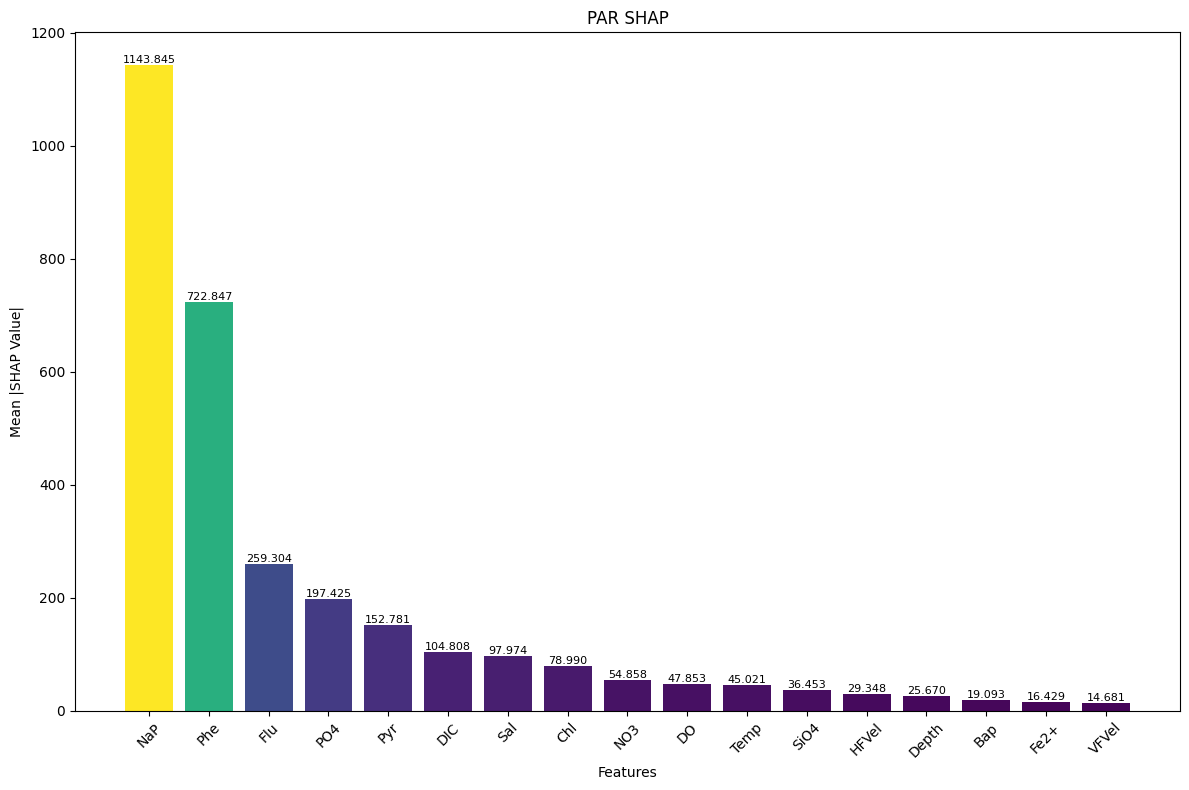

In [12]:
feature_names = [
    "Depth",        # depth
    "Temp",         # Temperature  
    "Sal",          # Salinity
    "HFVel",        # Horizontal Flow Velocity
    "VFVel",        # Vertical Flow Velocity
    "DO",           # Dissolved Oxygen
    "DIC",          # Dissolved Inorganic Carbon
    "NO3",          # Nitrate
    "PO4",          # Phosphate
    "SiO4",         # Silicate
    "Fe2+",         # Dissolved Iron Ions
    "Chl",          # Chlorophyll
    "NaP",    
    "Phe",    
    "Pyr",     
    "Bap",
    "Flu"
]
feature_importance = np.mean(np.abs(shap_values), axis=0).flatten()

# 按特征重要性从大到小排序
sorted_idx = np.argsort(feature_importance)[::-1]

sorted_importance = feature_importance[sorted_idx]
print(sorted_importance)
sorted_names = [feature_names[i] for i in sorted_idx]
# 绘制条形图
plt.figure(figsize=(12, 8))  # 调整图表尺寸
colors = plt.cm.viridis(sorted_importance / max(sorted_importance))  # 颜色映射
bars = plt.bar(range(len(sorted_importance)), sorted_importance, align='center', color=colors)

# 添加数值标签
for i, v in enumerate(sorted_importance):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=8)

# 设置横轴标签
plt.xticks(range(len(sorted_importance)), sorted_names, rotation=45)
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.title("PAR SHAP")
plt.tight_layout()


# 显示图表
plt.show()